# Delay coordinate embeddings in Lorenz using DynamicalSystems.jl

Adapted from the tutorial in JuliaDynamics repo:

https://github.com/JuliaDynamics/JuliaDynamics/blob/master/tutorials/Youtube_JuliaLang_tutorial/3.%20DelayEmbeddings.ipynb

In [1]:
# Uncomment if DynamicalSystems is not already present
#import Pkg
#Pkg.add("DynamicalSystems")

In [2]:
using DynamicalSystems
using PyPlot
PyPlot.rc("font", size = 16)          # set default fontsize
PyPlot.rc("figure", figsize = (6, 4)) # set default figsize

## Delay Coordinates Embedding
Often times one can only observe a single time series while the underlying dynamical system is composed of many variables. Is there a way to discover information about these unobserved variables? Takens theorem says that under certain conditions, a dynamical system can be reconstructed from a single time series. References:
 - http://www.scholarpedia.org/article/Attractor_reconstruction
 - https://www.youtube.com/watch?v=QQwtrWBwxQg
 - https://math.stackexchange.com/questions/3076299/why-lorenz-attractor-can-be-embedded-by-a-3-step-time-delay-map

### Summary:
 - Two hyperparameters: delay time, embedding dimension.
 - For Lorenz equations, Takens theorem gives the upper limit of 7 dimensions as the embedding dimension.
 - Appropriate delay time is usually guessed by the first minimum of the autocorrelation or the mutual information coefficient.

In [3]:
init_cond = [-8.0, 8.0, 27.0]

3-element Array{Float64,1}:
 -8.0
  8.0
 27.0

In [4]:
ds = Systems.lorenz(init_cond)

3-dimensional continuous dynamical system
 state:       [-8.0, 8.0, 27.0]
 e.o.m.:      loop
 in-place?    false
 jacobian:    loop_jac
 parameters:  [10.0, 28.0, 2.66667]

In [16]:
?Systems.lorenz

```julia
lorenz(u0=[0.0, 10.0, 0.0]; σ = 10.0, ρ = 28.0, β = 8/3) -> ds
```

$$
\begin{aligned}
\dot{X} &= \sigma(Y-X) \\
\dot{Y} &= -XZ + \rho X -Y \\
\dot{Z} &= XY - \beta Z
\end{aligned}
$$

The famous three dimensional system due to Lorenz [1], shown to exhibit so-called "deterministic nonperiodic flow". It was originally invented to study a simplified form of atmospheric convection.

Currently, it is most famous for its strange attractor (occuring at the default parameters), which resembles a butterfly. For the same reason it is also associated with the term "butterfly effect" (a term which Lorenz himself disliked) even though the effect applies generally to dynamical systems. Default values are the ones used in the original paper.

The parameter container has the parameters in the same order as stated in this function's documentation string.

[1] : E. N. Lorenz, J. atmos. Sci. **20**, pp 130 (1963)


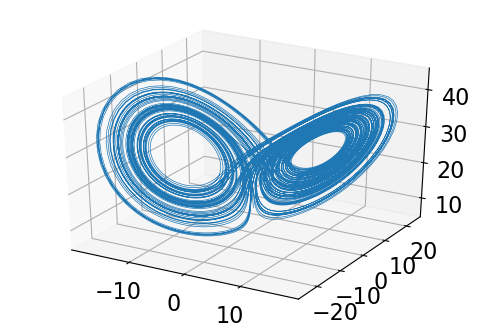

In [6]:
using PyPlot

dt = 0.01
data = trajectory(ds, 100.0, dt = dt)

#x,y,z = columns(data)
xyz = columns(data)

plot3D(xyz..., lw = 0.5);

In [7]:
size(data)

(10001, 3)

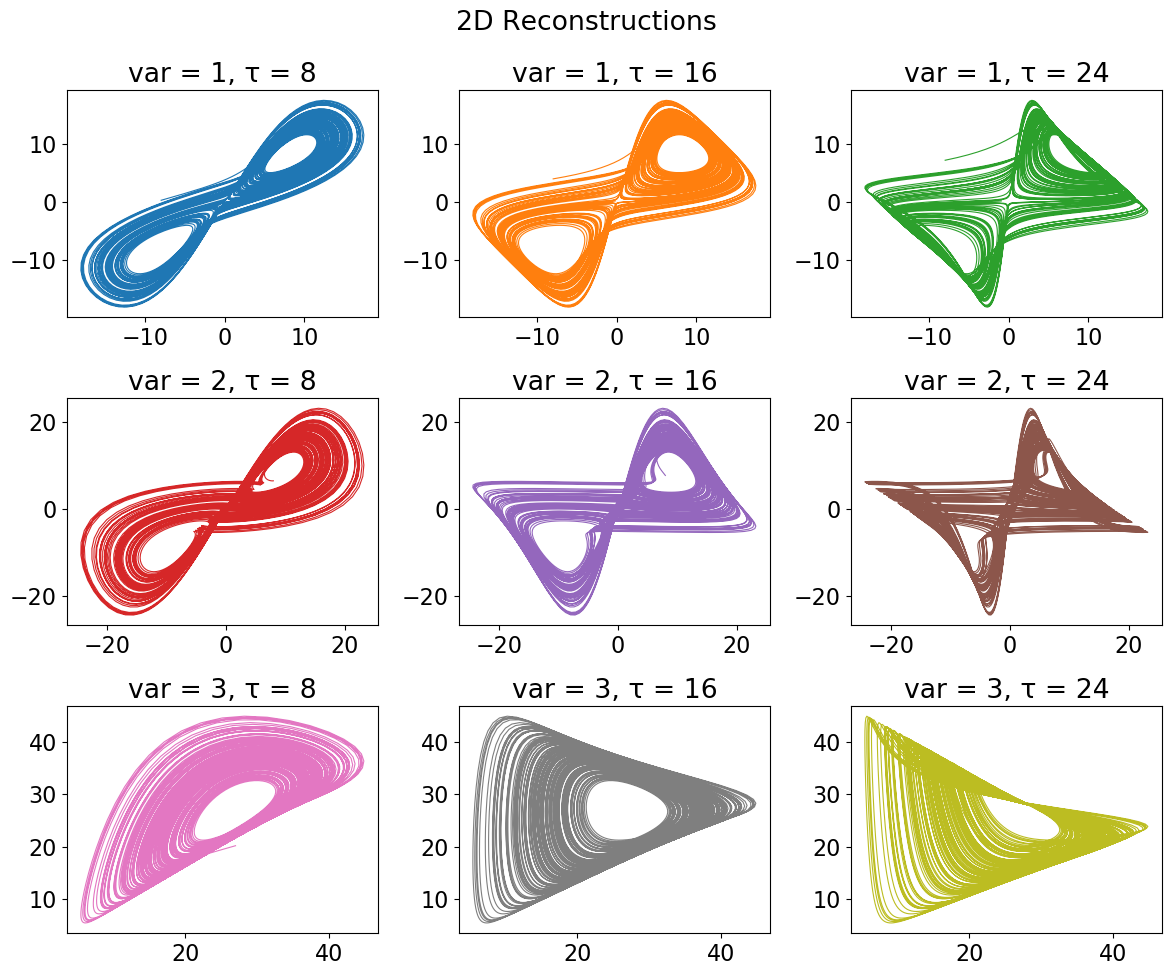

In [17]:
xyz = columns(data)

figure(figsize = (12,10))
k = 1
for i in 1:3
    for τ in [8, 16, 24]
        R = reconstruct(xyz[i], 1, τ)
        ax = subplot(3,3,k)
        plot(R[:, 1], R[:, 2], color = "C$(k-1)", lw = 0.8)
        title("var = $i, τ = $τ")
        k+=1
    end
end

tight_layout()
suptitle("2D Reconstructions")
subplots_adjust(top=0.9);

In [12]:
?estimate_delay

search: estimate_delay estimate_dimension estimate_period



```
estimate_delay(s, method::String [, τs = 1:2:100]; kwargs...) -> τ
```

Estimate an optimal delay to be used in [`reconstruct`](@ref) or [`embed`](@ref). The `method` can be one of the following:

  * `"ac_zero"` : first delay at which the auto-correlation function becomes <0.
  * `"ac_min"` : delay of first minimum of the auto-correlation function.
  * `"mi_min"` : delay of first minimum of mutual information of `s` with itself (shifted for various `τs`). Keywords `nbins, binwidth` are propagated into [`mutualinformation`](@ref).
  * `"exp_decay"` : [`exponential_decay_fit`](@ref) of the correlation function rounded  to an integer (uses least squares on `c(t) = exp(-t/τ)` to find `τ`).
  * `"exp_extrema"` : same as above but the exponential fit is done to the absolute value of the local extrema of the correlation function.

Both the mutual information and correlation function (`autocor`) are computed *only* for delays `τs`. This means that the `min` methods can never return the first value of `τs`!

The method `mi_min` is significantly more accurate than the others and also returns good results for most timeseries. It is however the slowest method (but still quite fast!).


In [13]:
s = data[:, 1]

methods = ["ac_zero", "mi_min", "exp_decay"]
for method in methods
    τ = estimate_delay(s, method, 0:1:400)
    println("For method = $(method), τ = $τ")
end

For method = ac_zero, τ = 191
For method = mi_min, τ = 19


ErrorException: The correlation function has elements that are ≤ 0. We can't fit an exponential to it. Please choose another method.

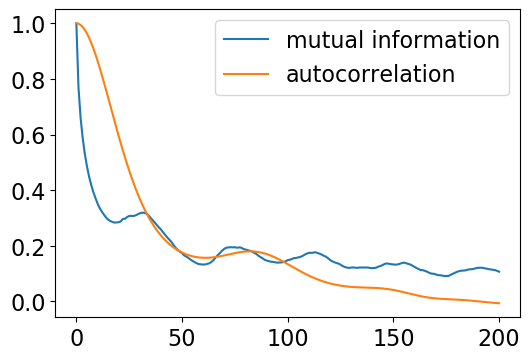

In [19]:
#Pkg.add("StatsBase")
using StatsBase

τ = 0:200
ac = autocor(s, τ)
mi = mutualinformation(s, τ)
plot(τ, mi ./ maximum(mi), label = "mutual information")
plot(τ, ac, label = "autocorrelation")
legend();